# California housing price predictions

## Topic
1. longitude: A measure of how far west a house is; a higher value is farther west

2. latitude: A measure of how far north a house is; a higher value is farther north

3. housingMedianAge: Median age of a house within a block; a lower number is a newer building

4. totalRooms: Total number of rooms within a block

5. totalBedrooms: Total number of bedrooms within a block

6. population: Total number of people residing within a block

7. households: Total number of households, a group of people residing within a home unit, for a block

8. medianIncome: Median income for households within a block of houses (measured in tens of thousands of US Dollars)

9. medianHouseValue: Median house value for households within a block (measured in US Dollars)

10. oceanProximity: Location of the house w.r.t ocean/sea

## Objective

## Summary

## Upload libraries

In [79]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

## Load the dataset

In [80]:
housing = pd.read_csv(r'C:\Users\imane\OneDrive\Desktop\California\housing.csv', sep =",")
housing.head(10)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   
5    -122.25     37.85                52.0        919.0           213.0   
6    -122.25     37.84                52.0       2535.0           489.0   
7    -122.25     37.84                52.0       3104.0           687.0   
8    -122.26     37.84                42.0       2555.0           665.0   
9    -122.25     37.84                52.0       3549.0           707.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  
5       413.0       193.0         4.0368            269700.0        NEAR BAY  
6      1094.0       514.0         3.6591            299200.0        NEAR BAY  
7      1157.0       647.0         3.1200            241400.0        NEAR BAY  
8      1206.0       595.0         2.0804            226700.0        NEAR BAY  
9      1551.0       714.0         3.6912            261100.0        NEAR BAY

## Exploratory data analysis

In [81]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Dataset contains 10 columns in total, 9 of which are floats and the last one is a categorical feature.

<AxesSubplot:>

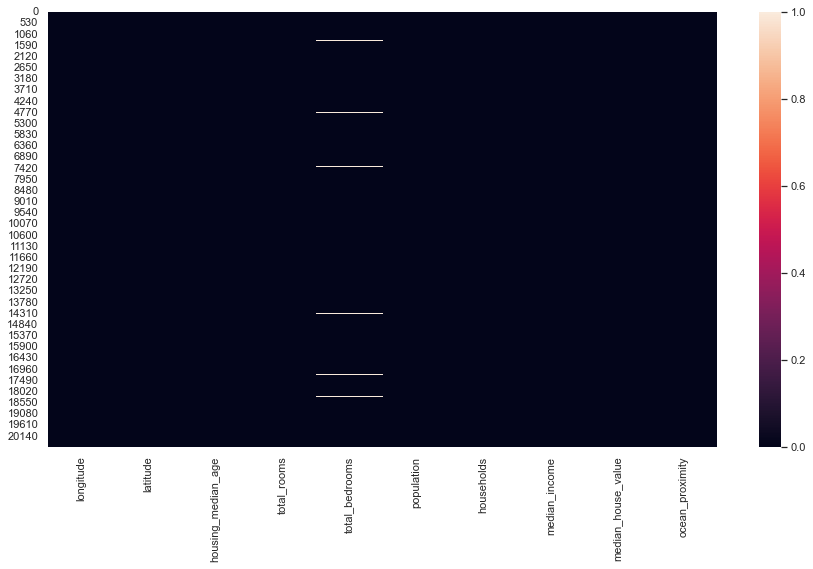

In [82]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(housing.isnull())

The only column containing empty values is the total bedrooms. It'll be delt with during the preprocessing step

array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'housing_median_age'}>],
       [<AxesSubplot:title={'center':'total_rooms'}>,
        <AxesSubplot:title={'center':'total_bedrooms'}>,
        <AxesSubplot:title={'center':'population'}>],
       [<AxesSubplot:title={'center':'households'}>,
        <AxesSubplot:title={'center':'median_income'}>,
        <AxesSubplot:title={'center':'median_house_value'}>]],
      dtype=object)

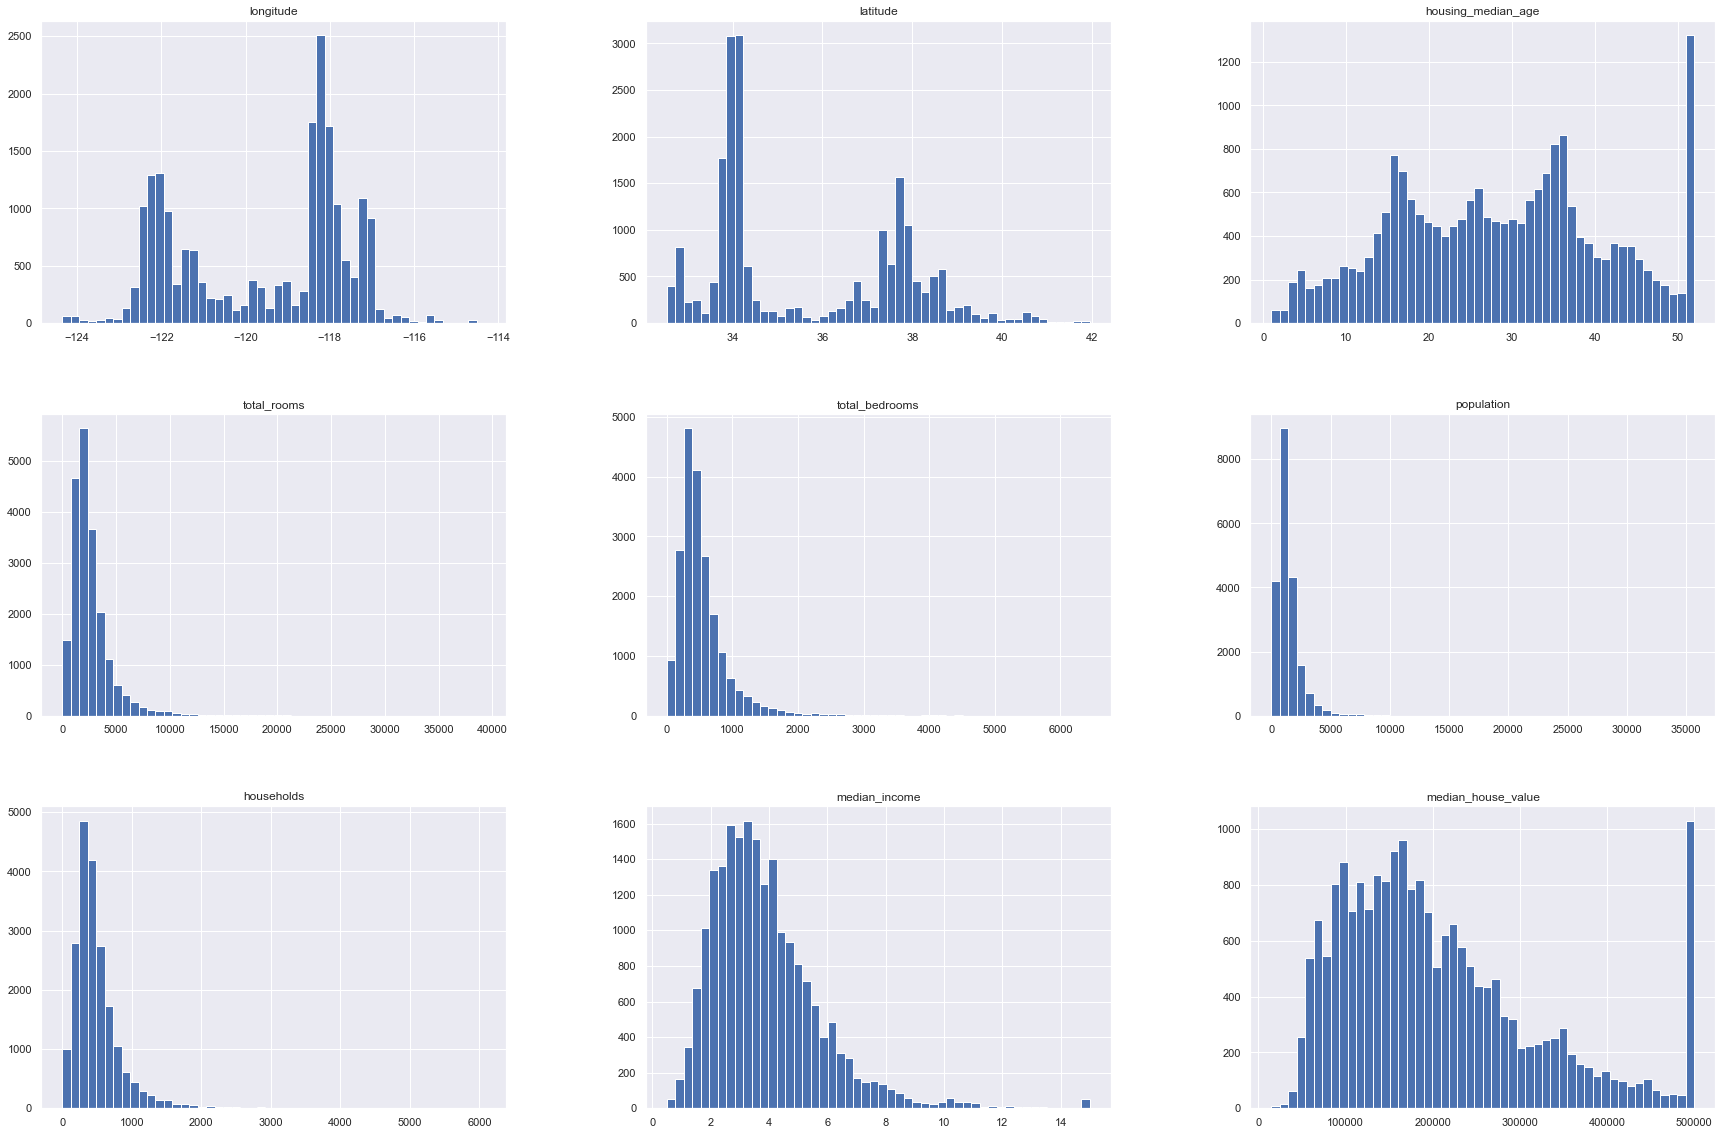

In [83]:
housing.hist(bins = 50 , figsize=(30 , 20))

Median income, housing median age and median house value all have been capped. For the latter, the capping would make the models assume that prices never go beyond 500 000 and it would do poorly in generalizing for prices above that value.
We can either fetch the actual values or delete the capped ones.

array([<AxesSubplot:ylabel='total'>], dtype=object)

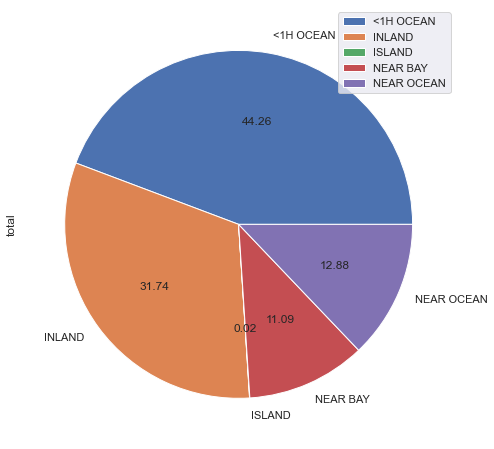

In [84]:
h = housing.copy()
total = [1 for i in range(len(h))]
h["total"] = total
fp = h.groupby("ocean_proximity").sum() 
fp = fp.drop(["longitude","latitude","housing_median_age","total_rooms","total_bedrooms","population","households",
             "median_income","median_house_value"],axis = 1)
fp.plot.pie(figsize=(10,8), subplots="True",autopct="%.2f")

Most houses in the area are less than 1 hour away from the sea. Followed by those located inland. The smallest percentage is that of houses on island.

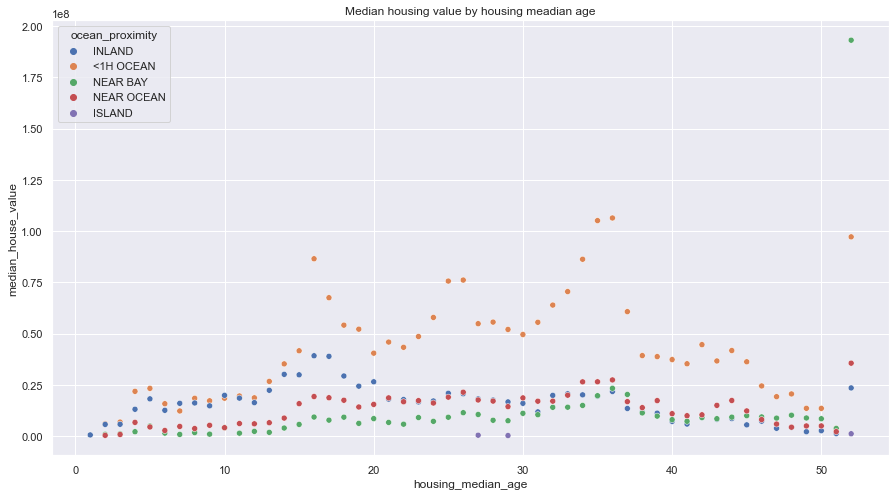

In [85]:
s = pd.DataFrame()
s["housing_median_age"] = housing["housing_median_age"]
s["median_house_value"] = housing["median_house_value"]
s["ocean_proximity"] = housing["ocean_proximity"]
s = s.groupby(["housing_median_age","ocean_proximity"]).sum().reset_index()
scatter = sns.scatterplot(data = s, x = "housing_median_age",y="median_house_value", hue="ocean_proximity").set(title = 
                                                                                                               "Median housing value by housing meadian age")

Overall, houses with less than 1 hour proximity to the ocean have the highest valuesespecially those whose median age is between 15 to 40 years old. Comes after it the values of the newly built inland houses then older near ocean houses. the houses near the bay have the least median value especially the newly built ones.

[Text(0.5, 1.0, 'Median house value by income category')]

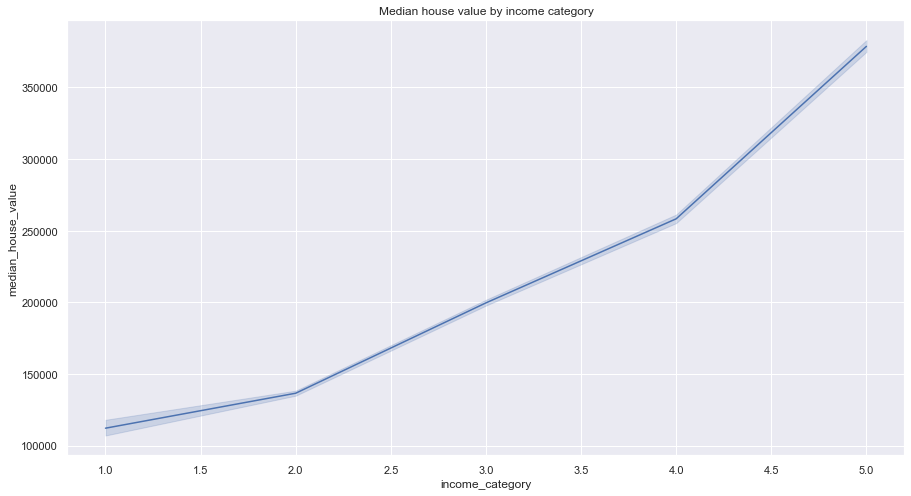

In [86]:
housing["income_category"] = pd.cut(housing["median_income"] , bins = [0 , 1.5 , 3.0 , 4.5 , 6 , np.inf] , 
                          labels=[1 , 2 , 3 , 4 , 5])
sns.lineplot(data = housing, x="income_category", y="median_house_value").set(title = "Median house value by income category")

The median income category column divides the median income into 5 categories and is expressed in tens of thousands of dollars:
- Values between 0 and 1.5 
- Values between 1.5 and 3.0
- Values between 3.0 and 4.5
- Values between 4.5 and 6.0
- Values above 6.0 (roughly refers to the values that were rounded)
From the lineplot we can see that the median value of the houses increases with the increase of the income.

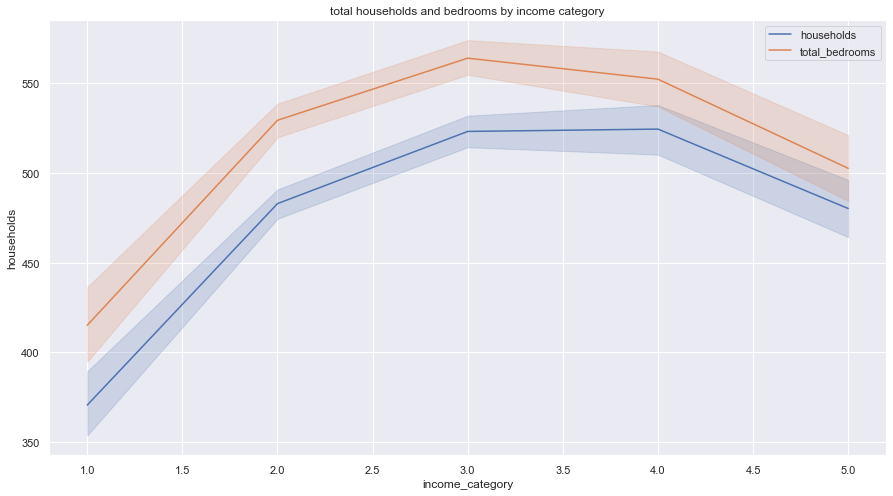

In [87]:
fig,ax = plt.subplots()
ax = sns.lineplot(data = housing,  x="income_category", y="households")
ax1 = sns.lineplot(data = housing,  x="income_category",y="total_bedrooms")
ax.set_title("total households and bedrooms by income category")
plt.legend(labels = ["households","total_bedrooms"])

Both the number of households and total bedrooms increase with the increase in income, untill the income reaches about 40 000 dollars where they start to gradually decrease.

In [88]:
housing = housing.drop("income_category", axis = 1)

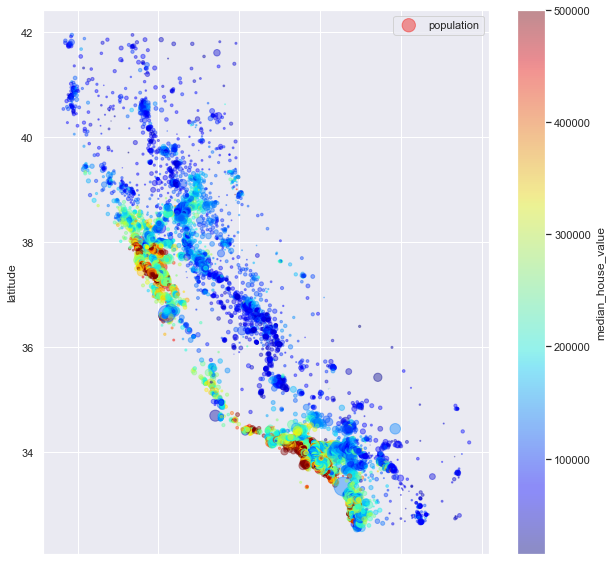

In [89]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
 s=housing["population"]/100, label="population", figsize=(10,10),
 c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

The map represents the distribution of houses based on their geaographical attributes, the density of the population and the values of the houses. The size of the redius if the circles is the density of the population (bigger circles mean higher population), and the colors represent the values (blue for lower values and red for higher values).
We can clearly see the presence of more people on the coastal side as well as fair density in the central area. The most expensice houses are located mainly by the bay.

In [90]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending= False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

Correlations between the numerical values and the target value (median house value) show us the following:
- The highest positive linear correlation is with the median income: the higher the income, the higher the median house value
- Other less significant positive correlations are with the total rooms and housing median age
- The lowest negative correlation is with the latitude, which means that prices tend to get lower as you move upnorth.

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

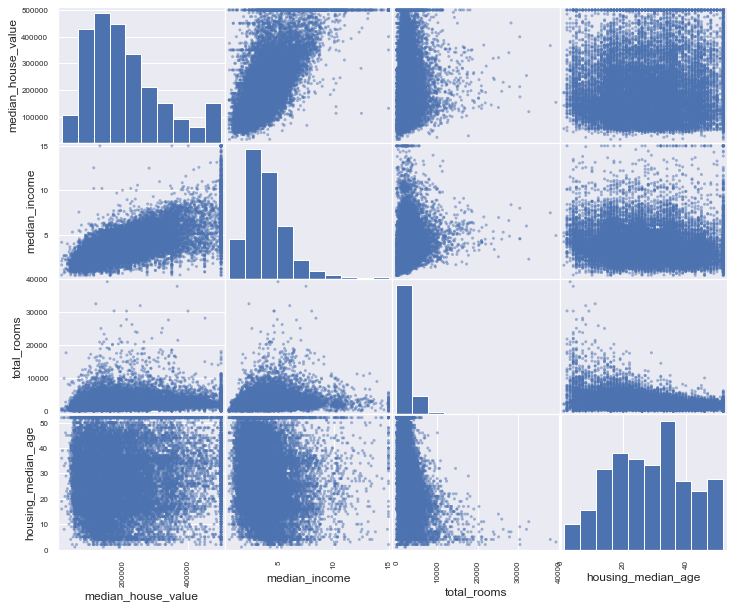

In [92]:
features = ["median_house_value", "median_income", "total_rooms",
 "housing_median_age"]
scatter_matrix(housing[features], figsize=(12, 10))

The scatter plot above is used to reveal the different correlations between numerical values. Only the first 3 features with the most correlation with the target were picked. Here the plot that represents the most obvious linear correlation is the one between the median house value and the midian income. This plot also shows us the capping at 500 000 with a straight line. There is also less obvious straight lines around the values of 450 000, 350 000 and 280 000. We might want to remove the corresponding districts to avoid the algorithms learning these quirks later.